# Self Organized Maps (SOMs) for EMU objects

Define the directory were all the files are saved.

In [80]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [81]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps

# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

# CuPY
# import cupy as cp

# Seaborn
import seaborn as sns

# Nans
import missingno

# Kolmorgorov-Smirnov
from scipy.stats import kstest

## PCA Whitening and ZPCA Whitening

[Link to Explanation](http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/)

[Link to Visualization](https://setosa.io/ev/principal-component-analysis/)

In [82]:
def pca_whitening(data, epsilon=1e-5):
    '''
    PCA whitening

    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data pca whitened
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

  
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    xPCAwhite = (whitening_matrix @ data_centered.T).T

    return xPCAwhite


def zca_whitening(data, epsilon=1e-5):
    '''
    ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data zca whitened

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_mean0 = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate x_rot and x_tilde
    x_rot = np.dot(data_mean0, eigvecs)

    # Whitening matrix: U * D^{-1/2} * U.T
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    # Apply whitening
    xZCAwhite = data_mean0 @ whitening_matrix
    
    return xZCAwhite

In [83]:
def inverse_pca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse PCA whitening

    Args:
        original_data: original data
        whitened_data: whitened data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_centered = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    D_sqrt = np.diag(np.sqrt(eigvals + epsilon))

    
    # Calculate the inverse of the PCA whitening matrix
    X_centered = whitened_data @ ((eigvecs @ D_sqrt @ eigvecs.T))
    
    x_dewhitened = X_centered + data_mean.values

    return x_dewhitened


def inverse_zca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_mean0 = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate the inverse of the ZCA whitening matrix
    D = np.diag(np.sqrt(eigvals + epsilon))
    inverse_zca_matrix = eigvecs @ D @ eigvecs.T

    # Apply inverse transform and add mean back
    x_orig = (inverse_zca_matrix @ whitened_data.T).T + data_mean.values

    return x_orig


## Run the SOM

Import the matched catalog from NWAY and convert it to a Pandas DataFrame.

In [84]:
# RADIUS (3''), EMU (1''), DESY6GOLD (0.1''), VIKINGDR5 (0.1''), CATWISE2020 (0.2''), No MAGNITUDES
# For a false detection rate of <10% 
# p_i>=0.1 & match_flag==1 & p_any>0.83
matched_no_mags_path = directory + 'cross_match/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_noMags/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_petro.fits'
matched_no_mags = Table.read(matched_no_mags_path)
matched_no_mags = matched_no_mags.to_pandas()

Filter using NWAY recomendations

In [85]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (matched_no_mags['match_flag'] == 1) & (matched_no_mags['p_i'] >= 0.1) & (matched_no_mags['p_any'] >=0.83)
catalog_matches_noMags = matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_noMags)}')

Number of objects in the catalog 11695


Select the objects that have matches in all the three surveys

In [ ]:
# Here we select objects that have matches in all three surveys
full_match_mask = (catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (catalog_matches_noMags['VKG_sourceID'] != -99) & (catalog_matches_noMags['CAT_source_id'] != b'-99')
catalog_matches_noMags_full = catalog_matches_noMags[full_match_mask]

# Ignore the warning
catalog_matches_noMags_full['EMU_island_name'] = catalog_matches_noMags_full['EMU_island_name'].str.decode('utf-8').str.strip(' ')

print(f'Number of objects in the catalog that have matches in all three surveys {len(catalog_matches_noMags_full)}')

Number of objects in the catalog that have matches in all three surveys 3855


/tmp/ipykernel_6353/1637635019.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_matches_noMags_full['EMU_island_name'] = catalog_matches_noMags_full['EMU_island_name'].str.decode('utf-8').str.strip(' ')


In [103]:
catalog_matches_noMags_full.head()

EMU_island_id EMU_island_name  EMU_n_components  \
27   b' SB53293_island_10003'  J005052-343426                 1   
55   b' SB53293_island_10012'  J005149-350743                 1   
75   b' SB53293_island_10014'  J010403-330523                 1   
100  b'  SB53293_island_1002'  J005648-350323                 1   
112  b' SB53293_island_10021'  J011324-324145                 1   

     EMU_ra_deg_cont  EMU_dec_deg_cont  EMU_freq  EMU_maj_axis  EMU_min_axis  \
27         12.716904        -34.573968     943.5          9.42          8.18   
55         12.954629        -35.128876     943.5         11.53          7.11   
75         16.016327        -33.089986     943.5         10.00          8.58   
100        14.203633        -35.056619     943.5         12.64         12.11   
112        18.351239        -32.696076     943.5          9.85          8.46   

     EMU_pos_ang  EMU_flux_int  ...  VKG_magerr_petro_h  VKG_magerr_petro_ks  \
27      2.860000         0.189  ...            0.051012             0.059202   
55    117.540001         0.192  ...            0.038362             0.039705   
75    153.309998         0.198  ...            0.101433             0.070069   
100   135.100006         4.763  ...            0.037212             0.030577   
112   107.150002         0.216  ...            0.023804             0.036767   

     VKG_mag_petro_z_ab_extcorr  VKG_mag_petro_y_ab_extcorr  \
27                    19.781342                   19.391724   
55                    18.363242                   18.311177   
75                    19.348789                   19.030014   
100                   18.276424                   17.987139   
112                   18.601618                   18.466670   

     VKG_mag_petro_j_ab_extcorr  VKG_mag_petro_h_ab_extcorr  \
27                    19.184131                   18.730108   
55                    18.026219                   17.765336   
75                    18.908129                   18.797529   
100                   17.861217                   17.503745   
112                   18.246934                   17.967421   

     VKG_mag_petro_ks_ab_extcorr  VKG_y_j_petro_extcorr  \
27                     18.438119               0.207593   
55                     17.527990               0.284958   
75                     18.350014               0.121886   
100                    17.302975               0.125922   
112                    17.710086               0.219736   

     VKG_j_h_petro_extcorr  VKG_h_ks_petro_extcorr  
27                0.454023                0.291989  
55                0.260883                0.237345  
75                0.110599                0.447515  
100               0.357472                0.200770  
112               0.279513                0.257335  

[5 rows x 185 columns]

In [88]:
# Define the columns for the som

som_columns = ['DESY6_mag_auto_g_extcorr',
                   'VKG_mag_petro_y_ab_extcorr',
                   'CAT_w1mpro_ab',
                   'DESY6_g_r_extcorr', 
                   'DESY6_r_i_extcorr', 
                   'DESY6_i_z_extcorr', 
                   'VKG_y_j_petro_extcorr', 
                   'VKG_j_h_petro_extcorr', 
                   'VKG_h_ks_petro_extcorr', 
                   'CAT_w1_w2_ab', 
                   'DESY6_spread_model_g']


catalog_som = catalog_matches_noMags_full[som_columns]

In [89]:
#missingno.matrix(catalog_som)

catalog_som = catalog_som.dropna()

#missingno.matrix(catalog_som)
print(len(catalog_som))

catalog_som.describe()

3535


DESY6_mag_auto_g_extcorr  VKG_mag_petro_y_ab_extcorr  CAT_w1mpro_ab  \
count               3535.000000                 3535.000000    3535.000000   
mean                  21.989663                   19.471295      18.611628   
std                    2.044072                    1.365551       0.801715   
min                   15.833063                   14.605186      14.646999   
25%                   20.550230                   18.595462      18.135000   
50%                   22.208226                   19.586487      18.652000   
75%                   23.464819                   20.508799      19.150000   
max                   34.550007                   23.194398      21.157999   

       DESY6_g_r_extcorr  DESY6_r_i_extcorr  DESY6_i_z_extcorr  \
count        3535.000000        3535.000000        3535.000000   
mean            1.185764           0.660732           0.411664   
std             0.590160           0.327876           0.233488   
min            -0.648590          -0.228563          -0.562861   
25%             0.806788           0.407582           0.274969   
50%             1.141765           0.592141           0.368284   
75%             1.523466           0.905088           0.496275   
max            10.291367           2.882668           1.457791   

       VKG_y_j_petro_extcorr  VKG_j_h_petro_extcorr  VKG_h_ks_petro_extcorr  \
count            3535.000000            3535.000000             3535.000000   
mean                0.270787               0.321544                0.306723   
std                 0.285614               0.298230                0.307016   
min                -2.517520              -3.010494               -4.377286   
25%                 0.142209               0.184011                0.150703   
50%                 0.246286               0.307977                0.281979   
75%                 0.372929               0.451324                0.434060   
max                 2.486458               3.055807                3.232750   

       CAT_w1_w2_ab  DESY6_spread_model_g  
count   3535.000000           3535.000000  
mean      -0.251675              0.014794  
std        0.336868              0.025220  
min       -1.522001             -0.050804  
25%       -0.479001              0.008734  
50%       -0.297001              0.014838  
75%       -0.095000              0.020490  
max        1.243000              1.000000

In [90]:
# plt.figure(figsize=(8,8))
# plt.scatter(catalog_som['EMU_ra_deg_cont'], catalog_som['EMU_dec_deg_cont'], s=10, alpha=0.7)
# plt.xlabel('RA (deg)', size = 10)
# plt.ylabel('Dec (deg)', size = 10)
# plt.title('EMU objects that have a match in all three catalogs')
# plt.grid(True)
# plt.gca().invert_xaxis()  # Optional: invert RA to match sky convention
# plt.tight_layout()
# plt.show()

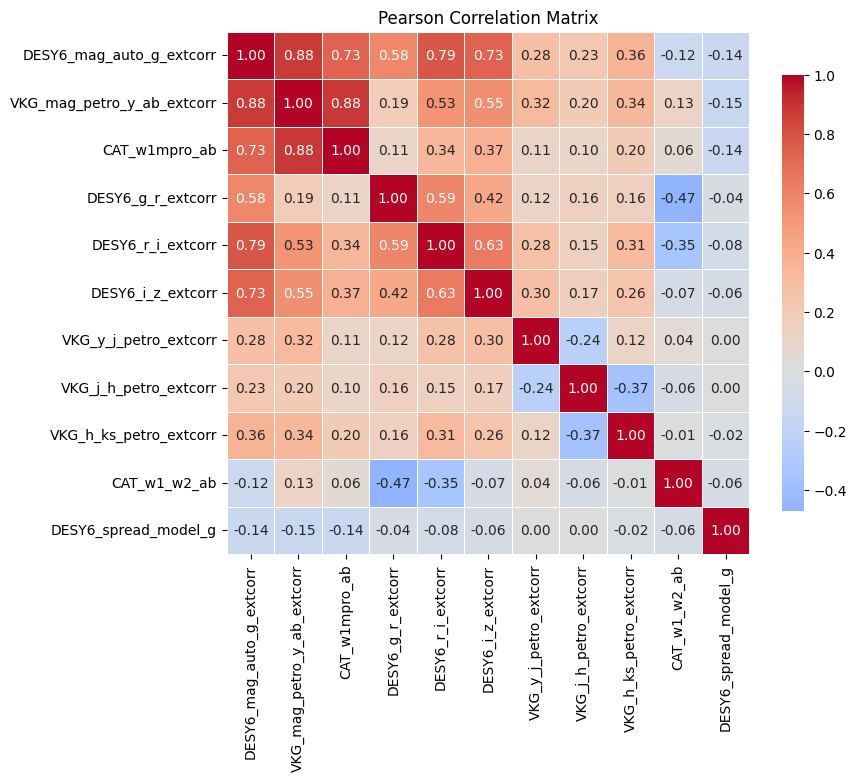

In [91]:
correlation_matrix = catalog_som.corr(method='pearson')
plt.figure(figsize = (9,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [92]:
# Define the data fraction to use: important if its too much data
data_fraction2use = 1
data = catalog_som.sample(frac=data_fraction2use)

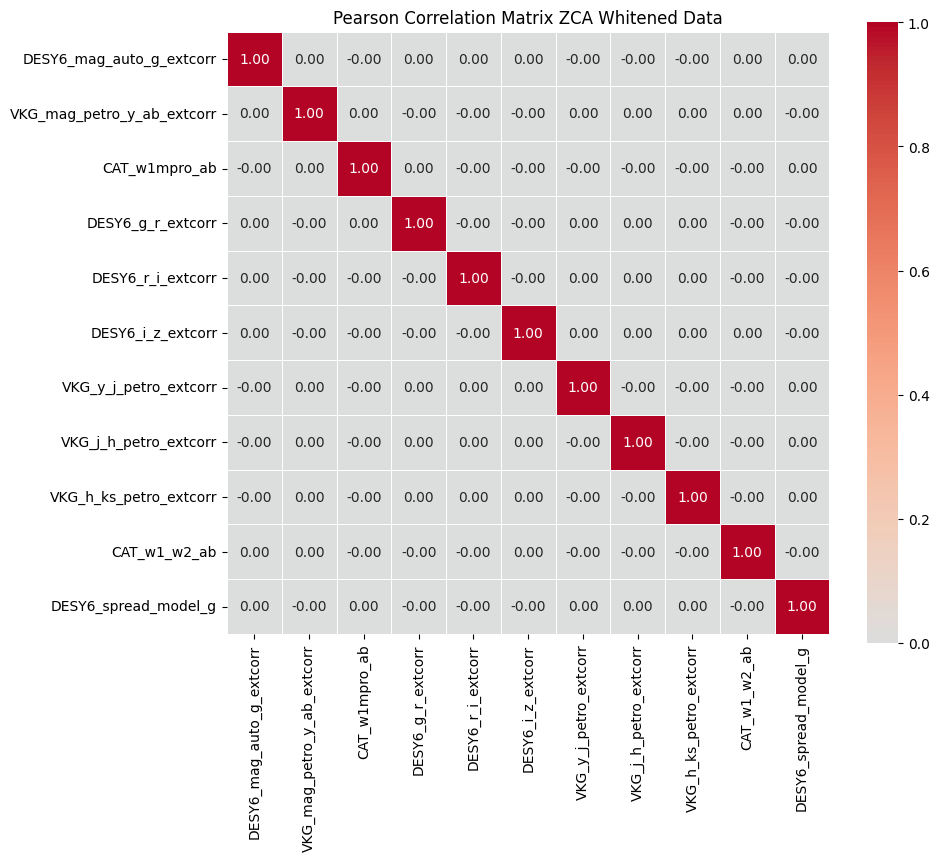

In [105]:
# Save the original data with id column and then remove it
data.columns = som_columns[:data.shape[1]]
data['id'] = catalog_matches_noMags_full['EMU_island_name']
data_path = '/home/polaris/Lab_Astro/data/soms/maps1/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_original.csv'
data.to_csv(data_path, index=False)
data = data.drop(columns=['id'])



# Save whitened data with id column and then remove it
data_white = zca_whitening(data)
data_white.columns = som_columns[:data_white.shape[1]]
data_white['id'] = catalog_matches_noMags_full['EMU_island_name']
data_white_path = '/home/polaris/Lab_Astro/data/soms/maps1/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_zcaWhite.csv'
data_white.to_csv(data_white_path, index=False)

# Remove the id column for the correlation matrix
data_white = data_white.drop(columns=['id'])


###############################################################################################################################
correlation_matrix = data_white.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix ZCA Whitened Data")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Define the SOM topology

In [ ]:
# SOM topology (lattice size)

data = np.array(data_white)

# Number of sources in our dataframe
inputdata_size = len(data_white)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_matrix = np.cov(data_white, rowvar=False)
eigen_values = np.linalg.eigvals(cov_matrix)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes is 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Resize the SOM map by applying a scaling factor that maintains the aspect ratio

scaling_factor = 2  # Change this factor to resize the map

# Apply scaling to the x dimension, and calculate y dimension based on ratio
som_x_resized = int(som_x * scaling_factor)
som_y_resized = int(som_x_resized / ratio_eigenvalues)  # Keep the same ratio of eigenvalues

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('Ratio of the two largest eigenvalues: ', int(ratio_eigenvalues))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

print('Resized SOM map size using eigenvalues: ', som_x_resized, 'x', som_y_resized)

Dimension of the SOM:  297
Square SOM map size  17.0
Ratio of the two largest eigenvalues:  1
SOM map size using eigenvalues:  17 x 16
Resized SOM map size using eigenvalues:  34 x 33


### Run the SOM

In [ ]:
# Define the SOM
som = sps.SOMNet(
    2,
    2,
    data_white,
    load_file = None,
    metric = 'euclidean', # 'euclidian' or 'cosine' or 'manhattan'
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = False,
    random_seed = 6942,
    topology='hexagonal', # 'square' or 'hexagonal'
    debug= True,
    output_path = '/home/polaris/Lab_Astro/data/soms/maps3/epoch_files'
)

# Train the SOM
som.train(
    train_algo = 'batch', 
    epochs = 5,
    # start_learning_rate = 0.01 , # Used only for online training
    early_stop = None ,
    early_stop_patience = 3 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

2025-05-19 15:11:48.748 | INFO     | simpsom.network:__init__:111 - Periodic Boundary Conditions active.
2025-05-19 15:11:48.754 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-19 15:11:48.759 | INFO     | simpsom.network:_set_weights:196 - The weights will be initialized randomly.
2025-05-19 15:11:48.762 | INFO     | simpsom.network:train:469 - The map will be trained with the batch algorithm.
/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/network.py:483: RuntimeWarning: divide by zero encountered in scalar divide
  self.tau = self.epochs / self.xp.log(self.start_sigma)
2025-05-19 15:11:48.976 | INFO     | simpsom.network:save_map:307 - Map shape and weights will be saved to:
/home/polaris/Lab_Astro/data/soms/maps3/epoch_files/trained_som_0epoch.npy
2025-05-19 15:11:49.187 | INFO     | simpsom.network:save_map:307 - Map shape and weights will be saved to:
/home/polaris/Lab_Astro/data/soms/maps3/epoch_files

/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/distances.py:178: RuntimeWarning: invalid value encountered in sqrt
  return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))
2025-05-19 15:11:51.438 | INFO     | simpsom.network:get_nodes_difference:697 - Weights difference among neighboring nodes calculated.
/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/plots.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f'{t:.3f}' for t in ticks])


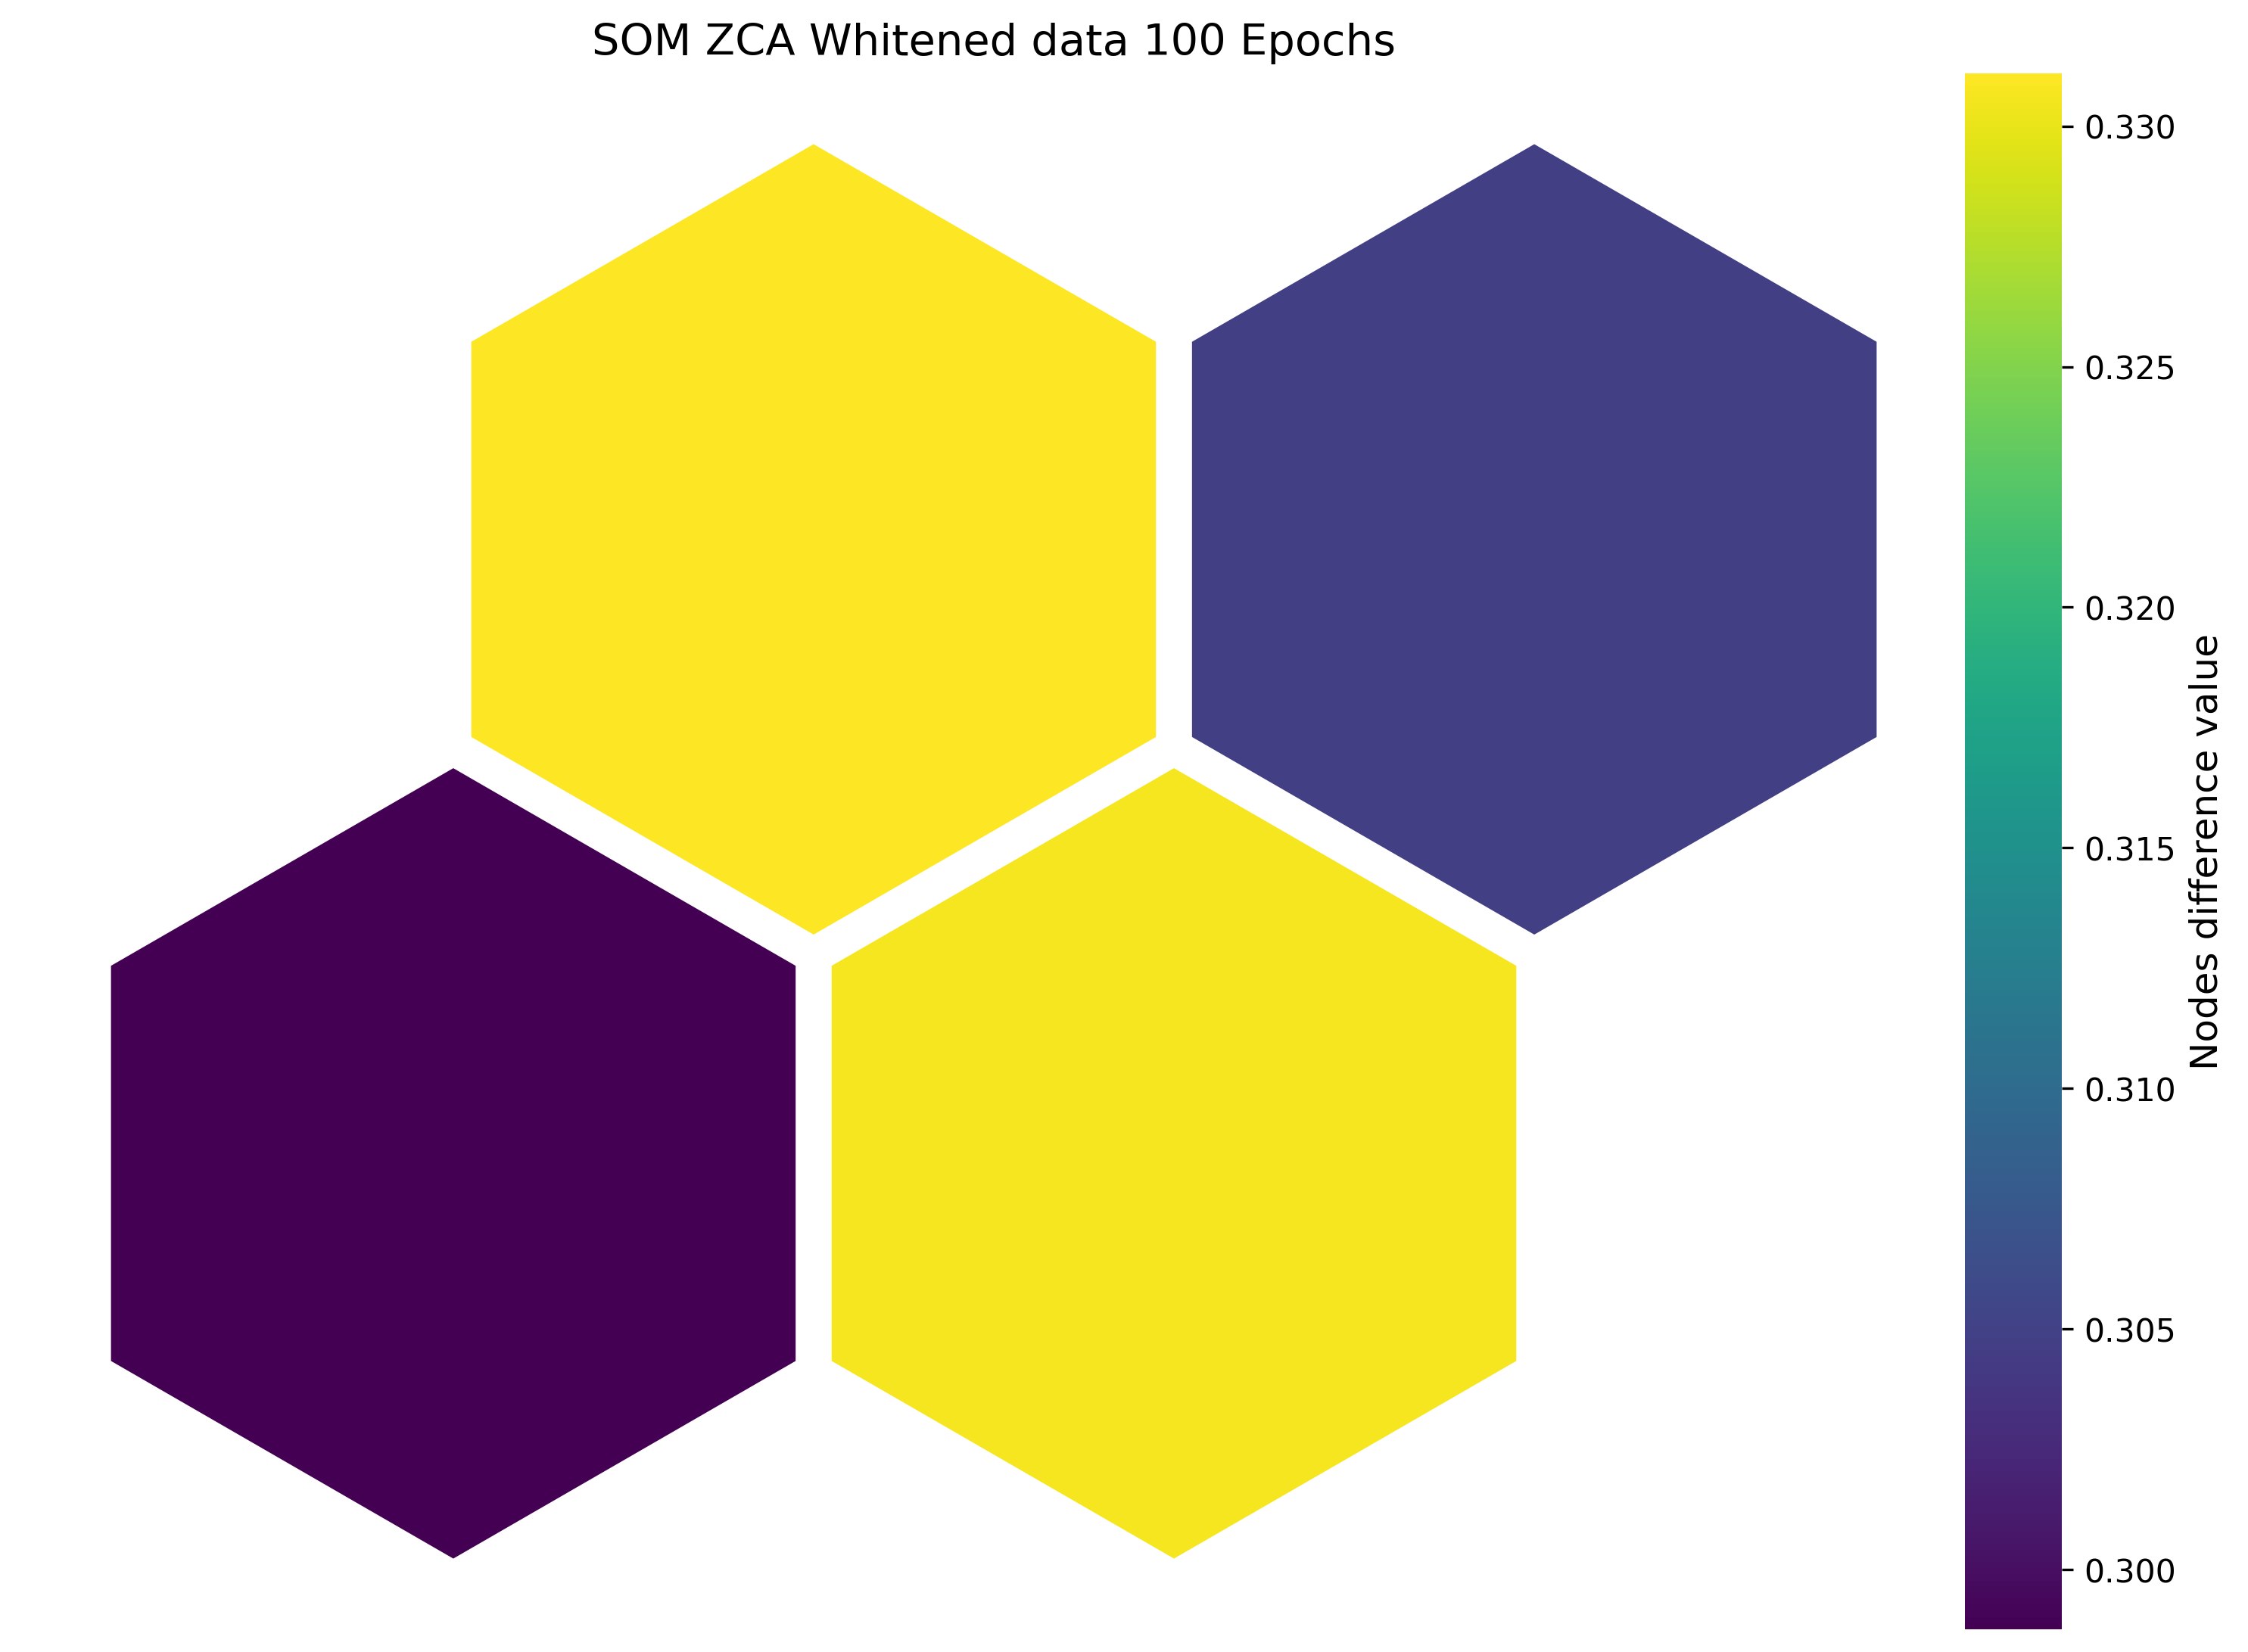

In [ ]:
som.plot_map_by_difference(show=True, print_out=False, title='SOM ZCA Whitened data 100 Epochs', figsize=(10,10))

## Quantization Error (QE) and Topographic Error (TE)

In [ ]:
quantization_error=[]
topographic_error=[]


for i in range(0,4):
    name_file = directory + 'soms/maps3/epoch_files/trained_som_' + str(i) + 'epoch'+ '.npy'
    
    # Define the SOM
    sommap = sps.SOMNet(
    3,
    3,
    data_white,
    load_file = name_file,
    debug= False,
    metric = 'euclidean',
    topology= 'hexagonal'
    )

    # Add errors to list
    quantization_error.append(sommap.calculate_qe(len(data)))
    topographic_error.append(sommap.calculate_te(len(data)))

# Print the errors
print('Quantization error: ', quantization_error)
print('Topographic error: ', topographic_error)

2025-05-19 17:28:11.444 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-19 17:28:11.447 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.


2025-05-19 17:28:13.029 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-19 17:28:13.031 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-19 17:28:14.566 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-19 17:28:14.567 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-19 17:28:15.763 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-19 17:28:15.764 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.


Quantization error:  [25.01005744934082, 2.84521222114563, 2.814699649810791, 2.791844129562378]
Topographic error:  [0.0, 0.0, 0.0, 0.0]


[25.01005744934082, 2.84521222114563, 2.814699649810791, 2.791844129562378]
[0.0, 0.0, 0.0, 0.0]


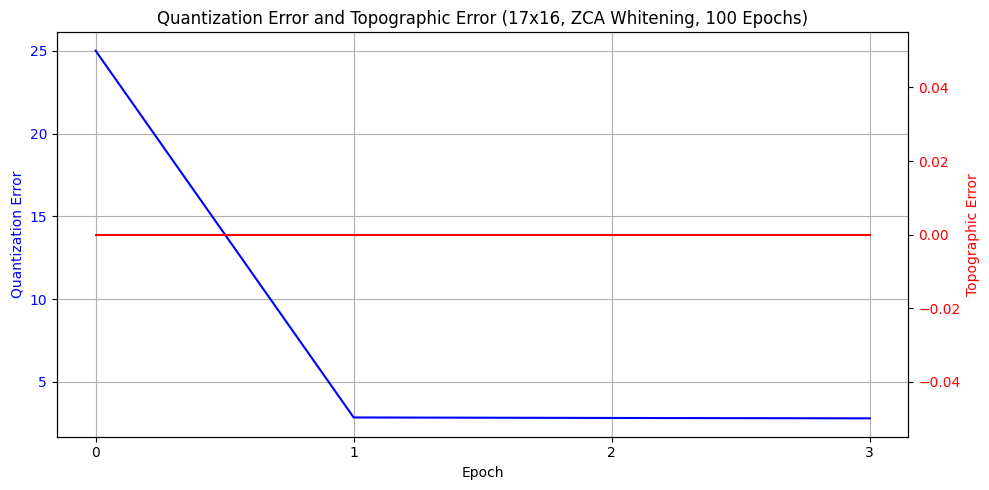

In [ ]:
print(quantization_error)
print(topographic_error)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Quantization Error on the primary y-axis
ax1.plot(quantization_error, label='Quantization Error', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Quantization Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', labelcolor='black')
ax1.set_xticks(range(len(quantization_error)))
ax1.grid()

# Create a secondary y-axis for Topographic Error
ax2 = ax1.twinx()
ax2.plot(topographic_error, label='Topographic Error', color='red')
ax2.set_ylabel('Topographic Error', color='red')
ax1.tick_params(axis='x', labelcolor='black')
ax1.set_xticks(range(len(quantization_error)))
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Quantization Error and Topographic Error (17x16, ZCA Whitening, 100 Epochs)')
fig.tight_layout()
plt.show()

## Prototypes

In [ ]:
best_epoch = 40
best_som_path = directory + '/soms/maps1//epoch_files/trained_som_' + str(best_epoch) + 'epoch'+ '.npy'

# Define the SOM
best_som = sps.SOMNet(
    17,
    16,
    data_white,
    load_file = best_som_path,
    debug= False,
    )

2025-05-12 22:44:05.227 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-12 22:44:05.231 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.


### Prototype Maps

/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/plots.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f'{t:.3f}' for t in ticks])
/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/plots.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f'{t:.3f}' for t in ticks])
/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/plots.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f'{t:.3f}' for t in ticks])
/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/plots.py:72:

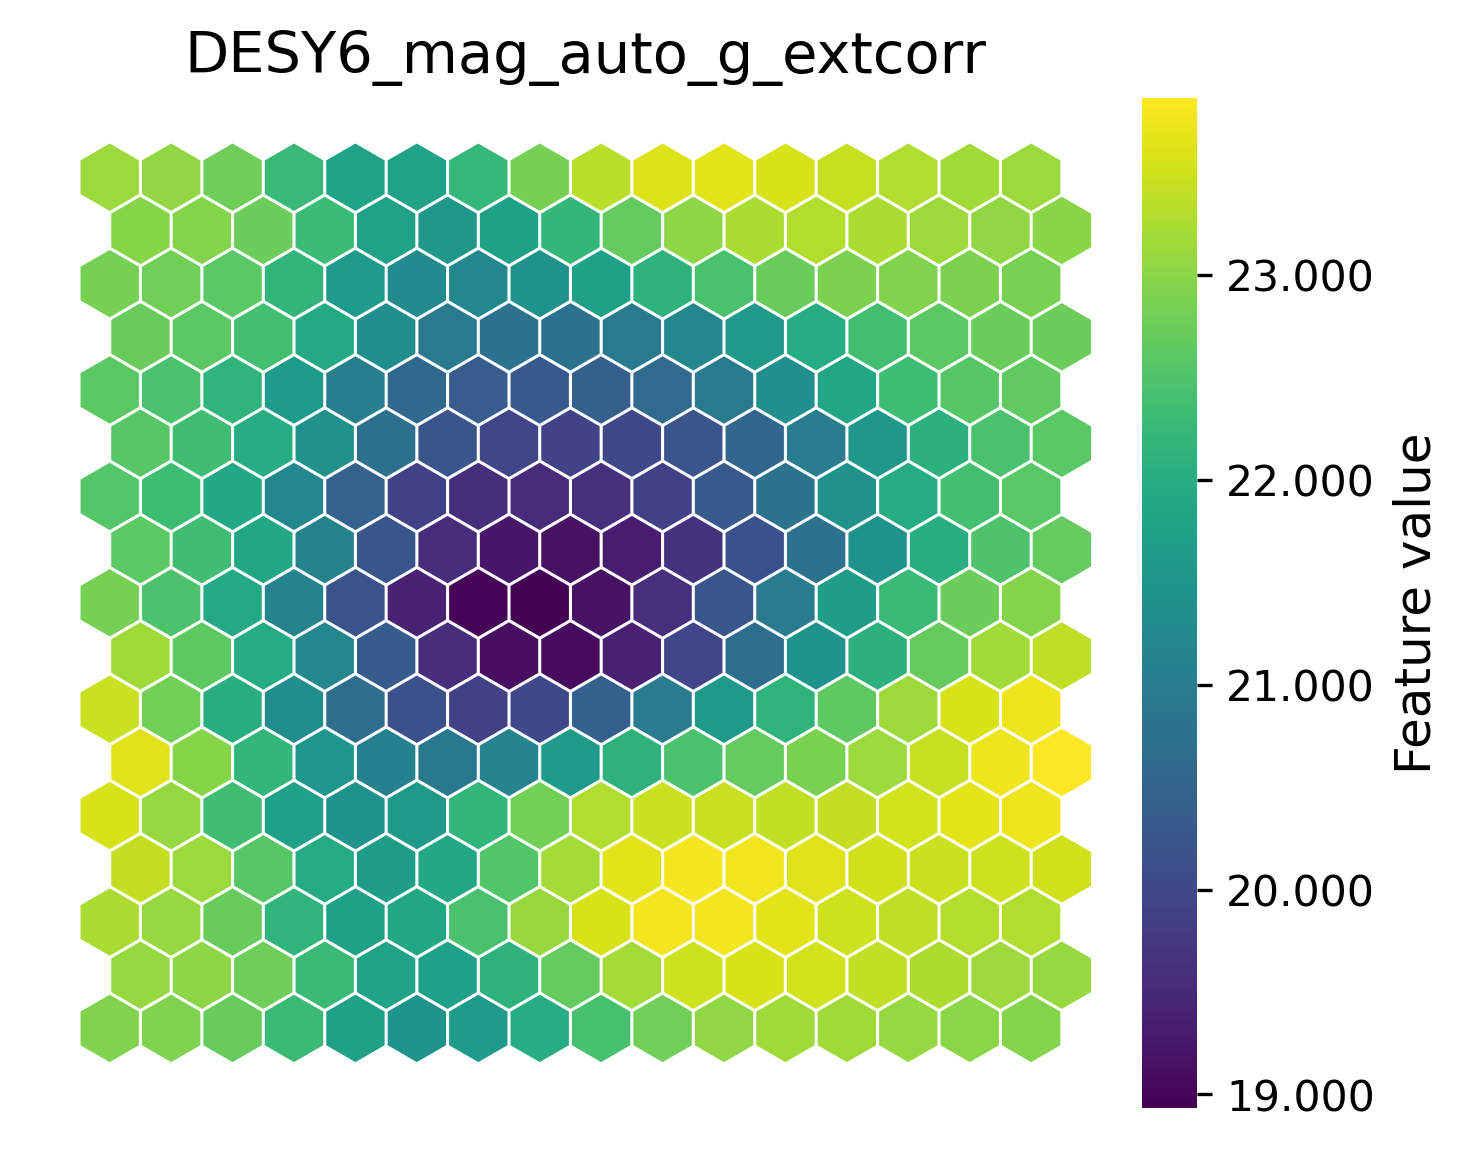

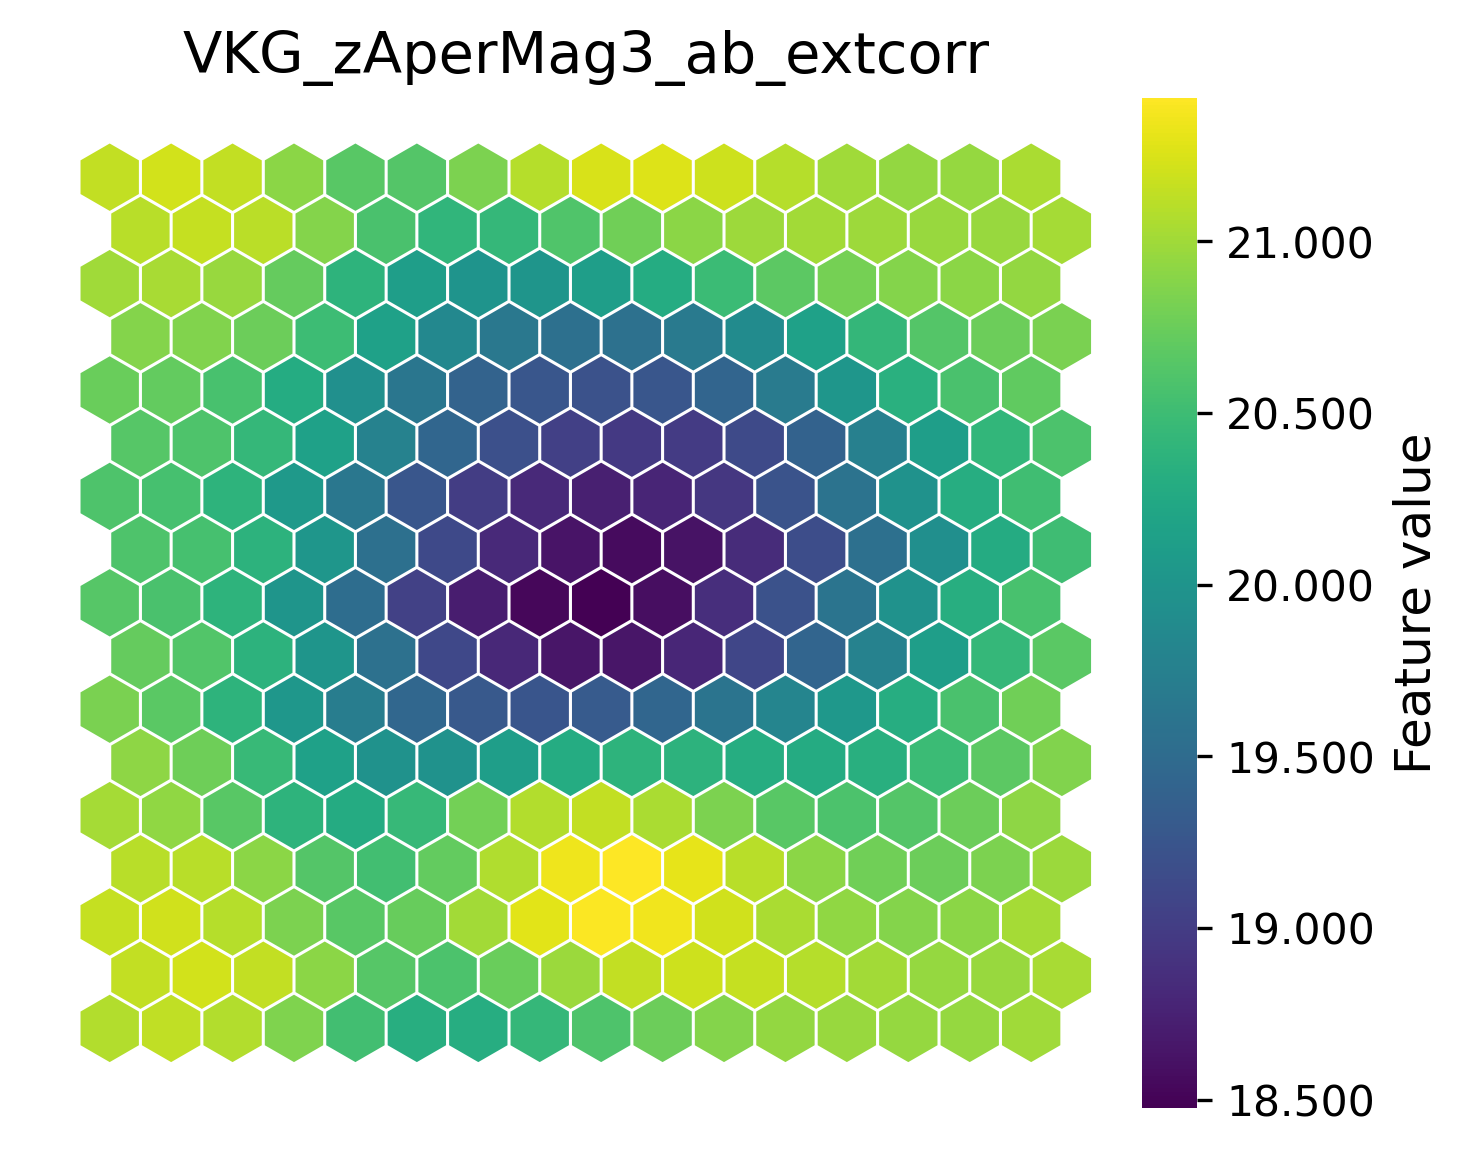

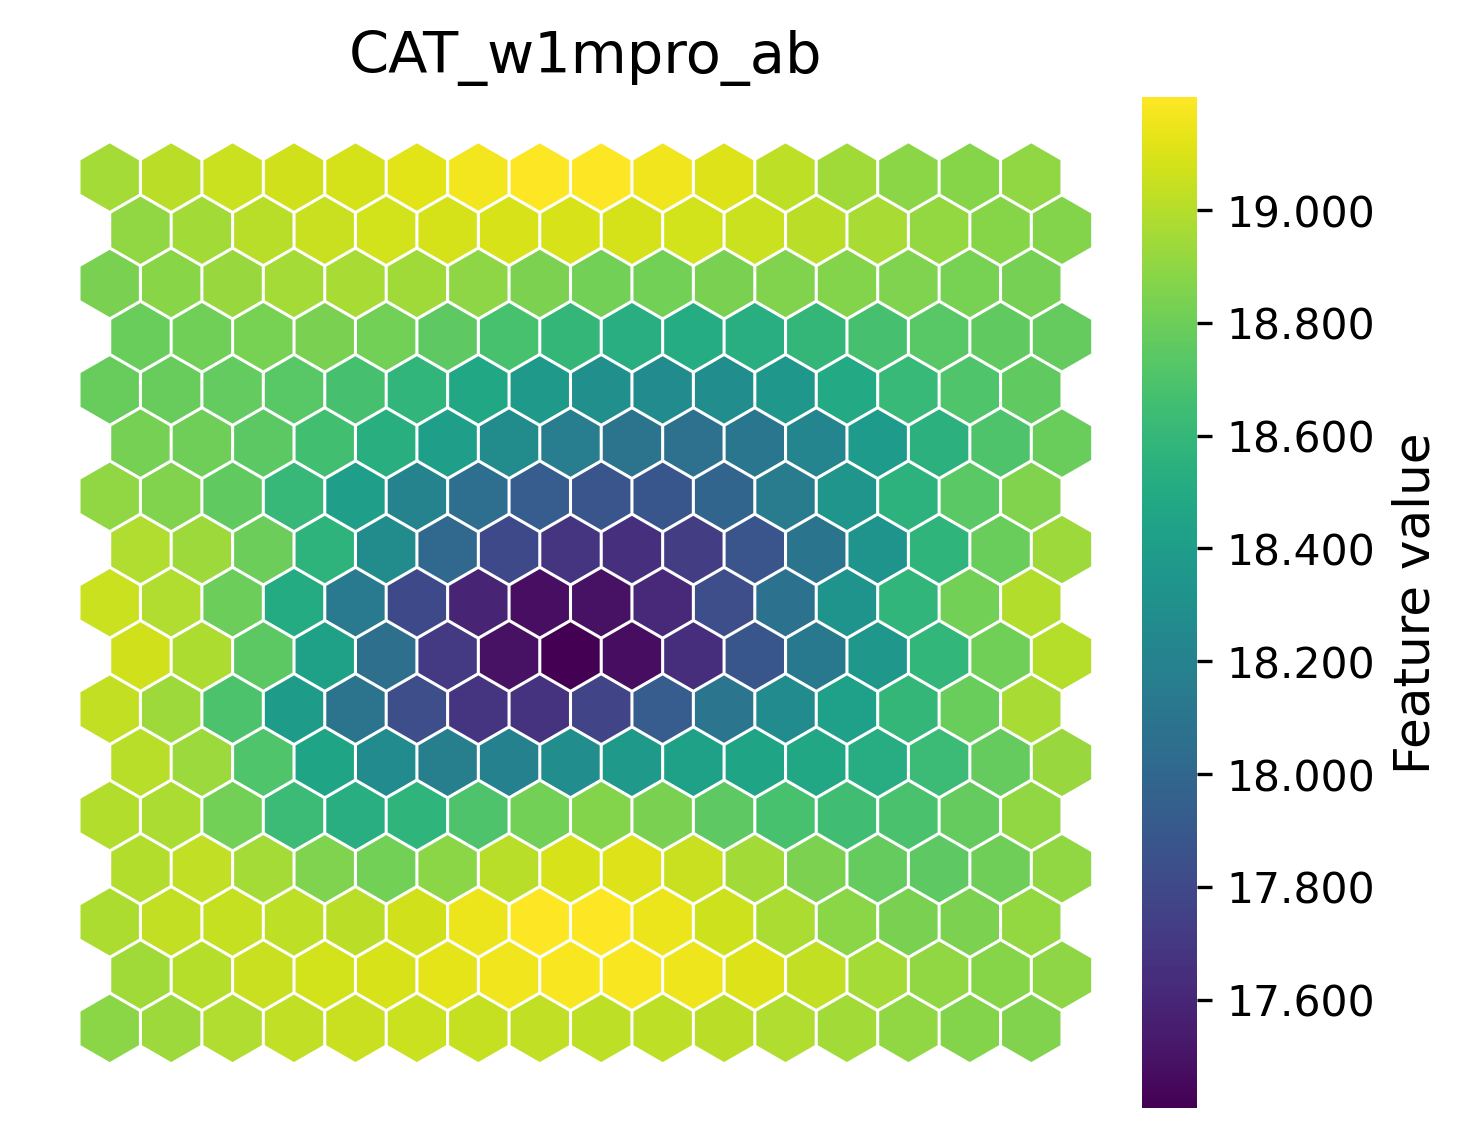

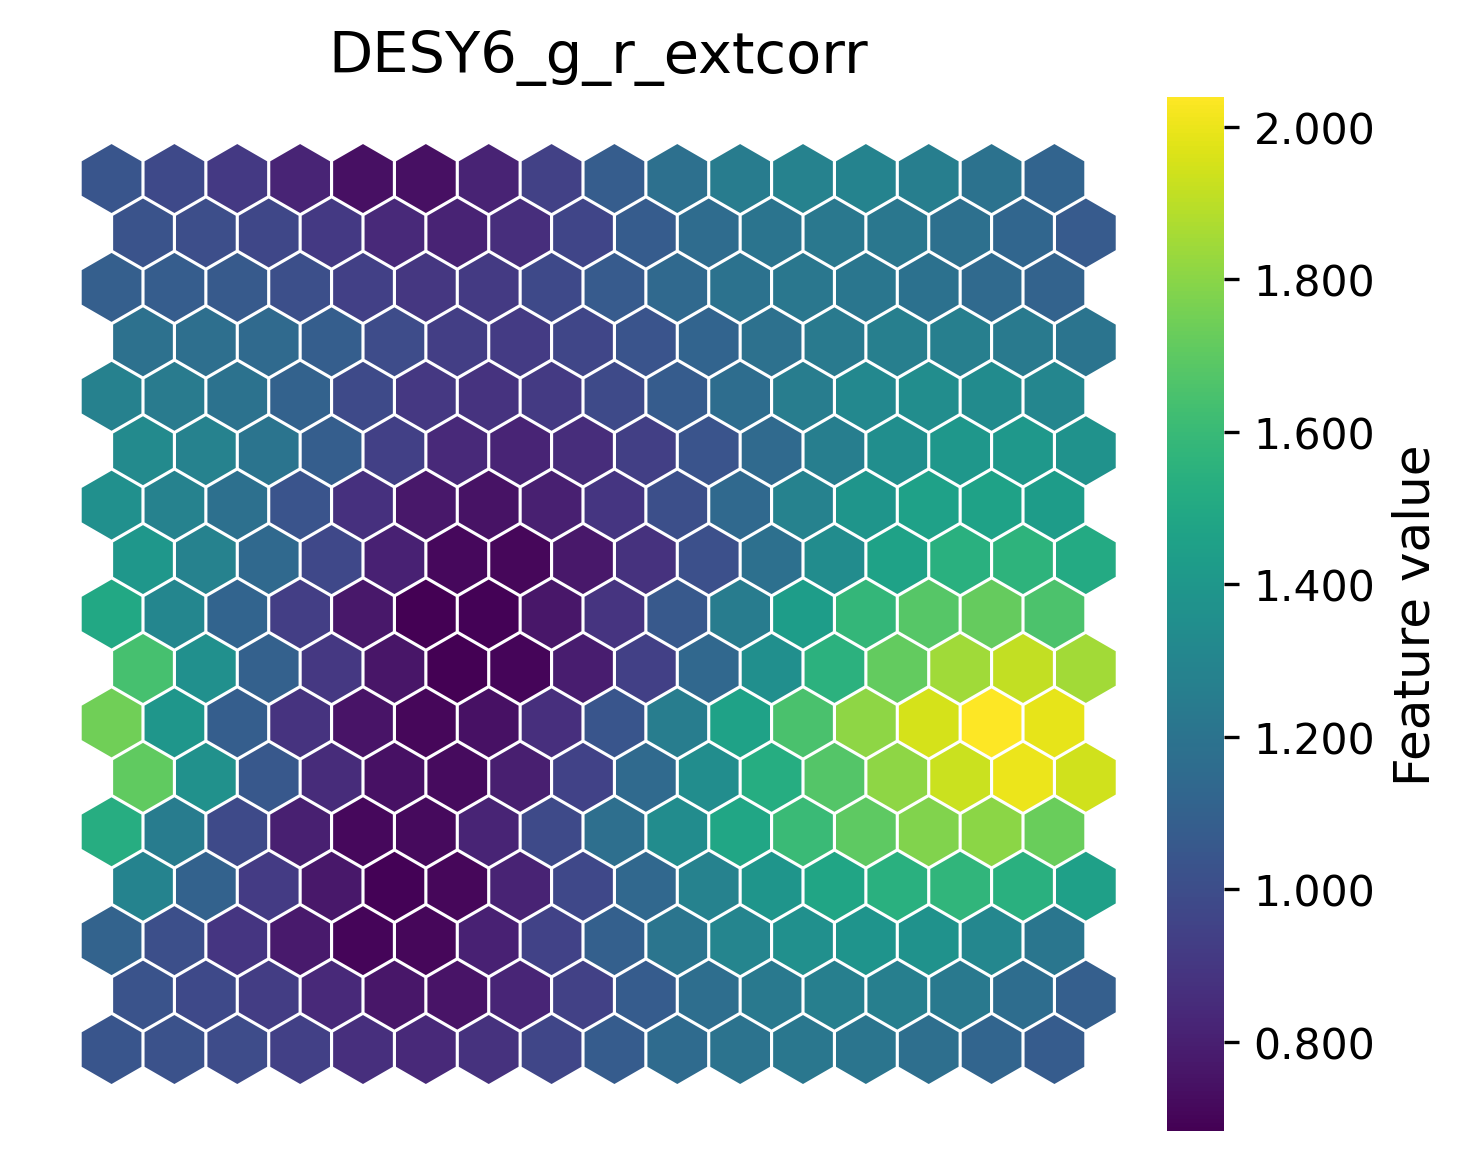

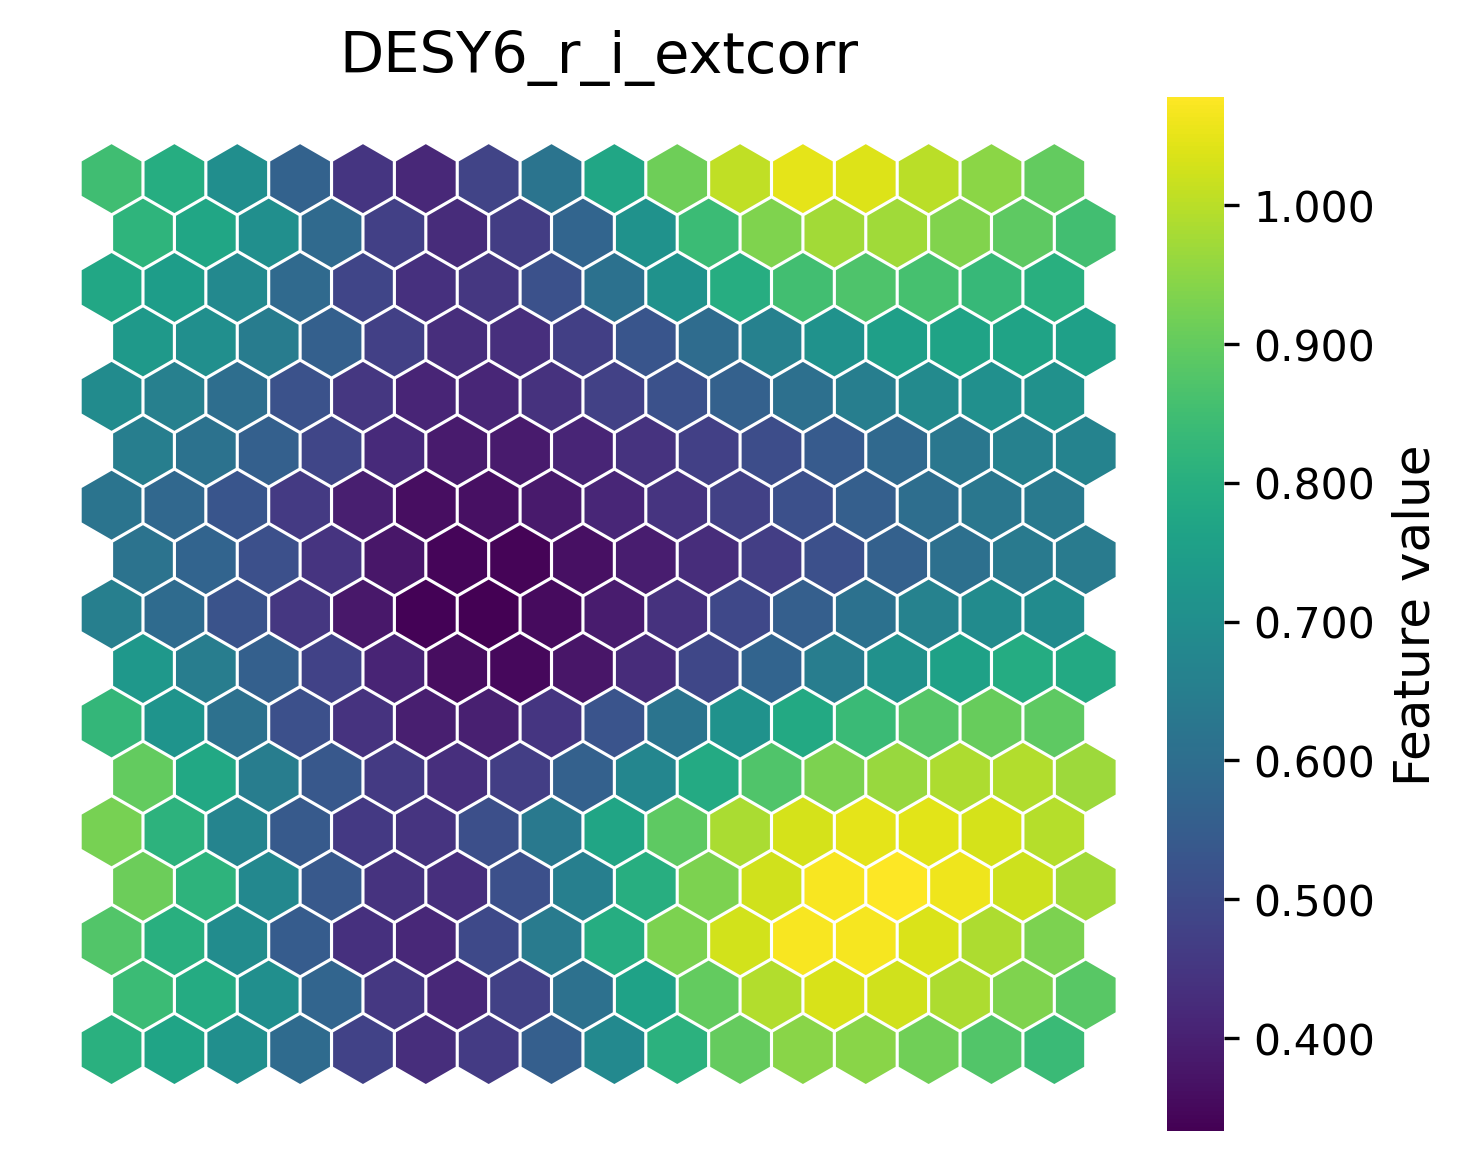

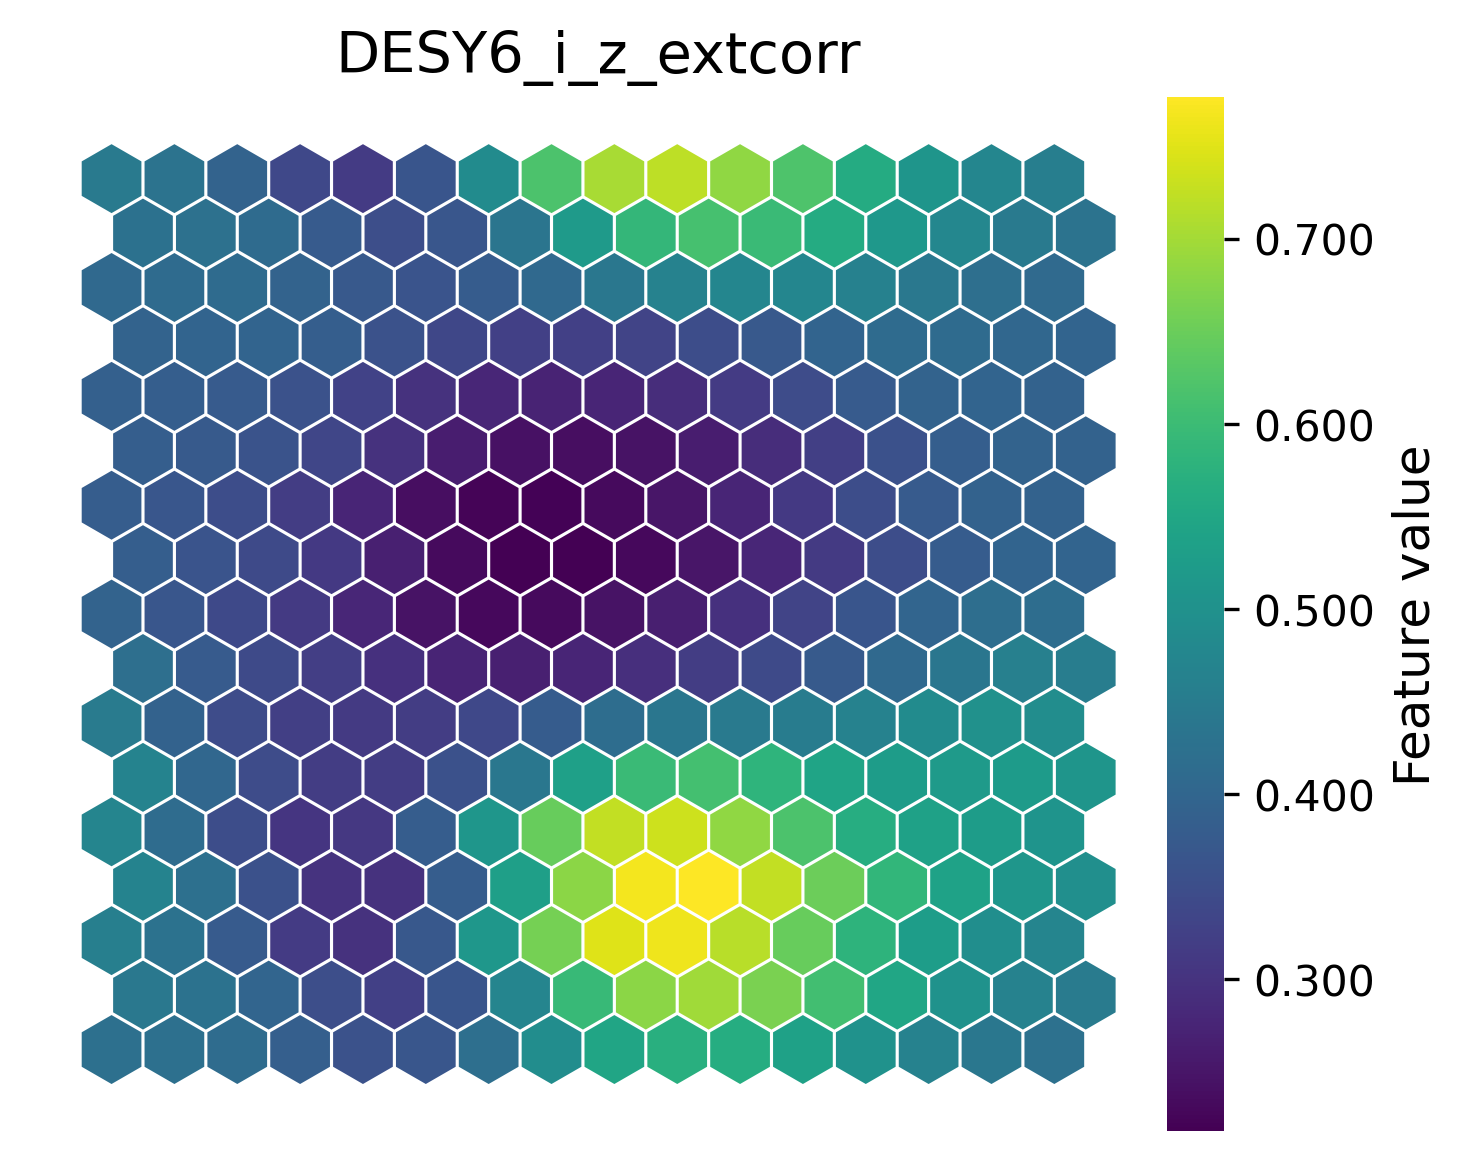

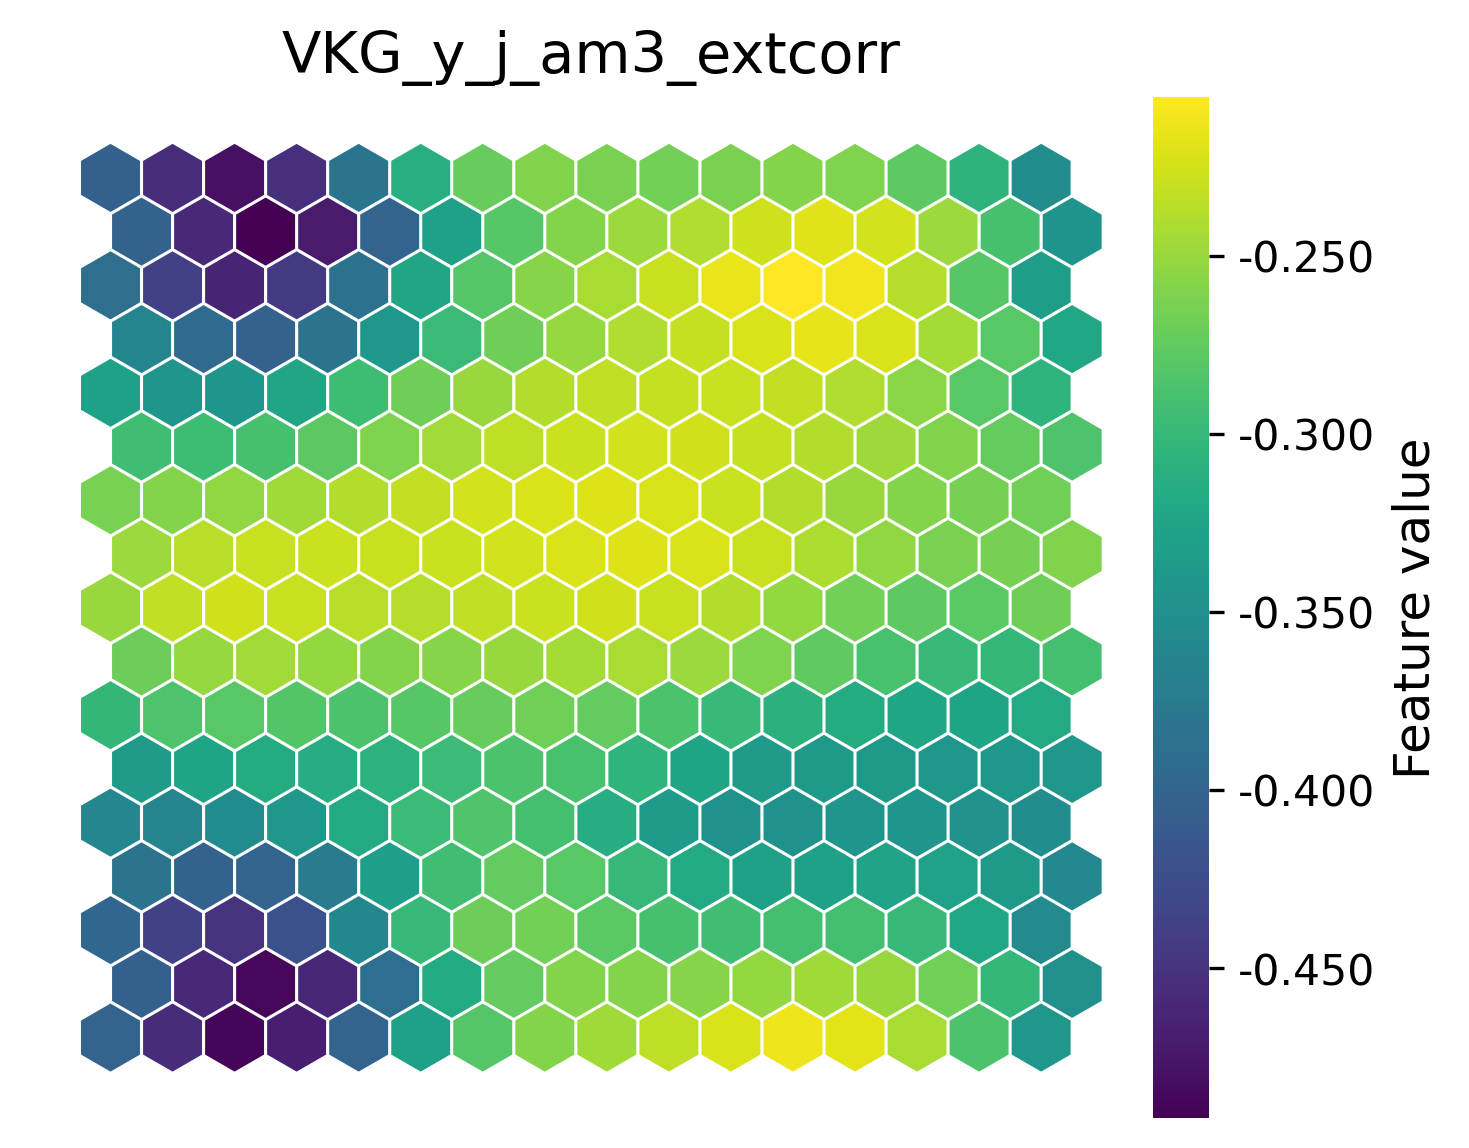

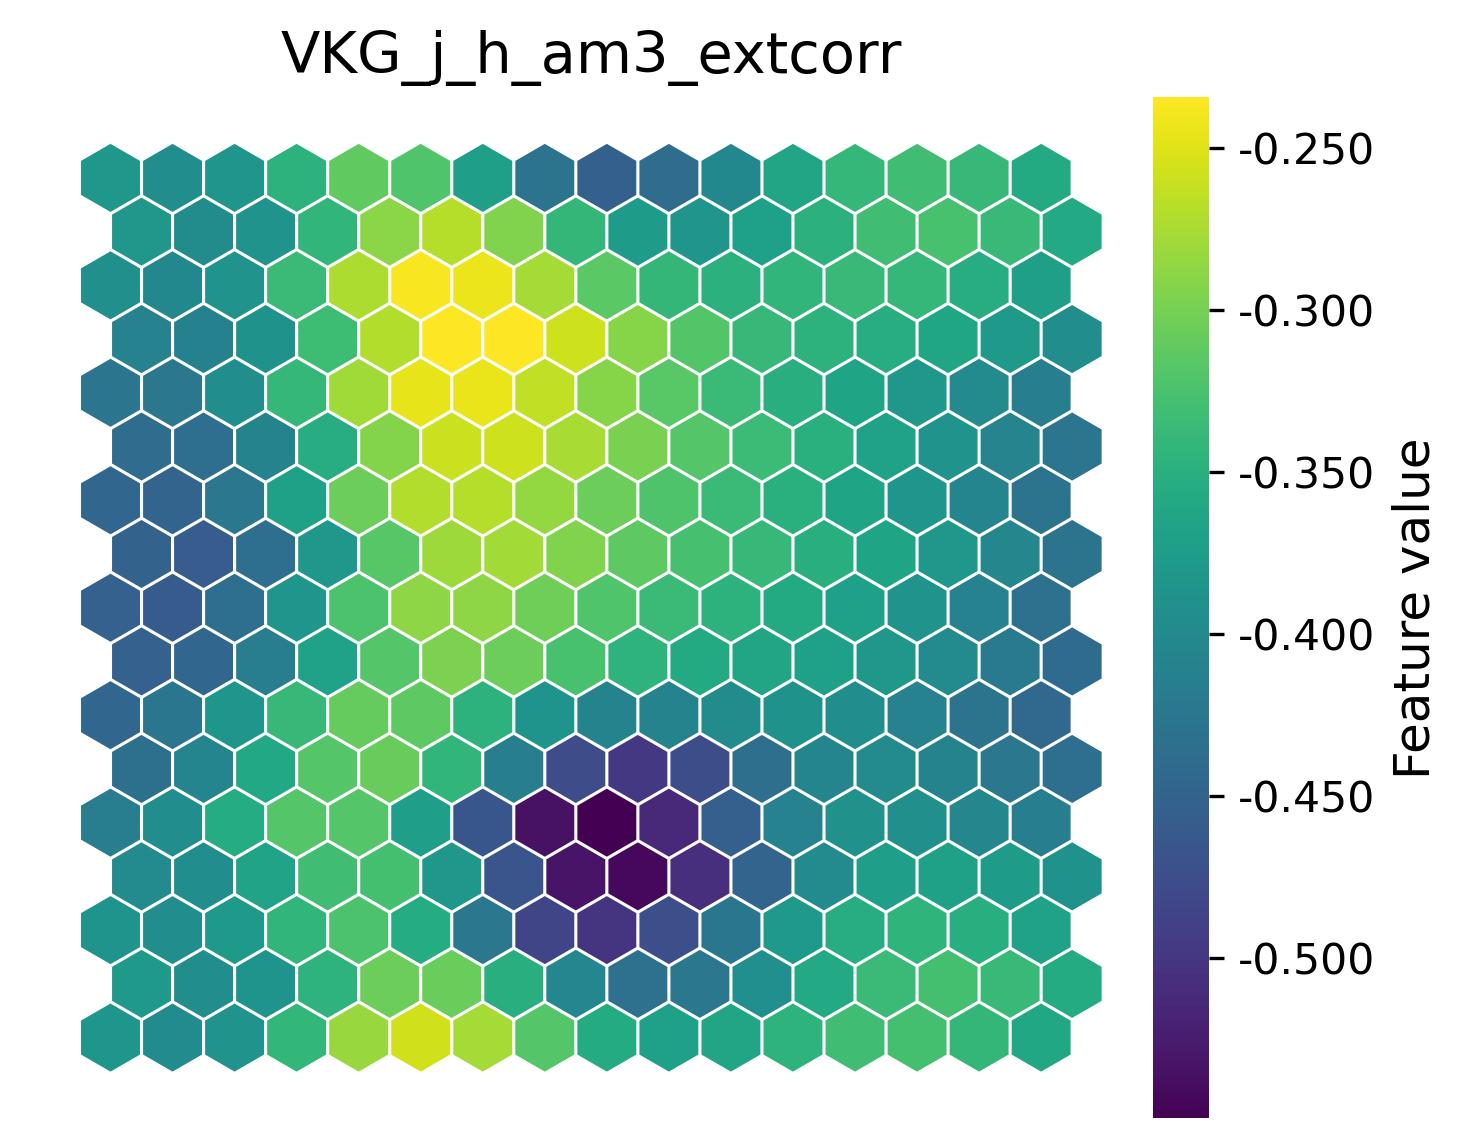

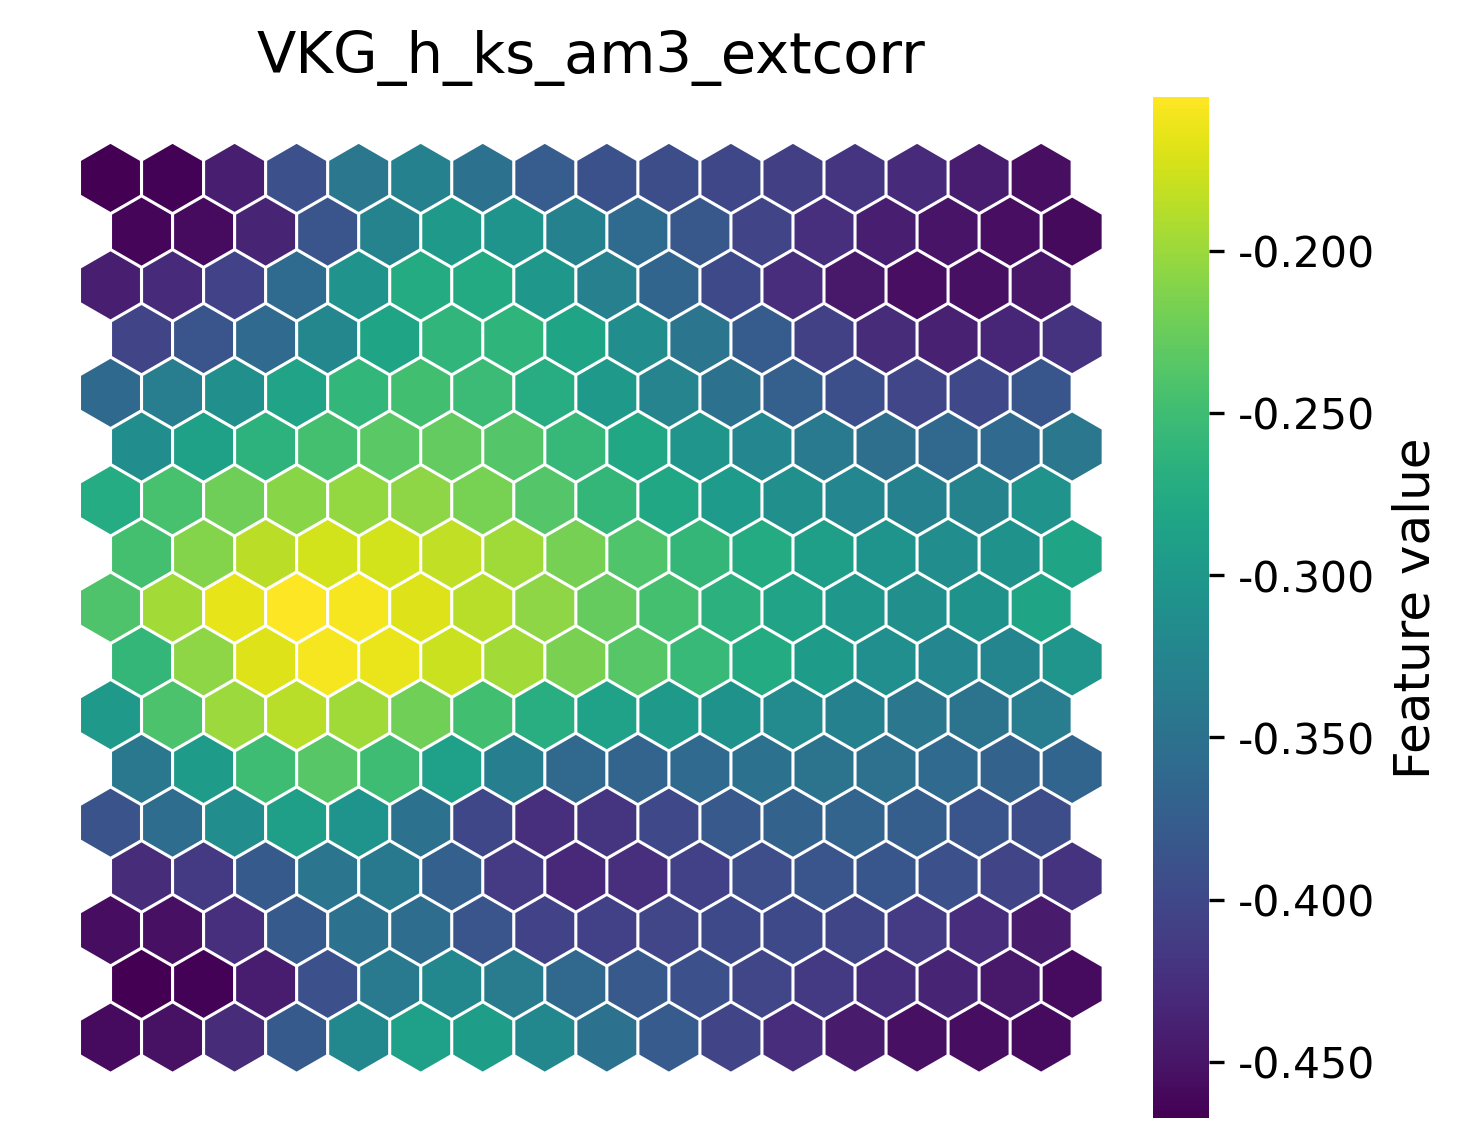

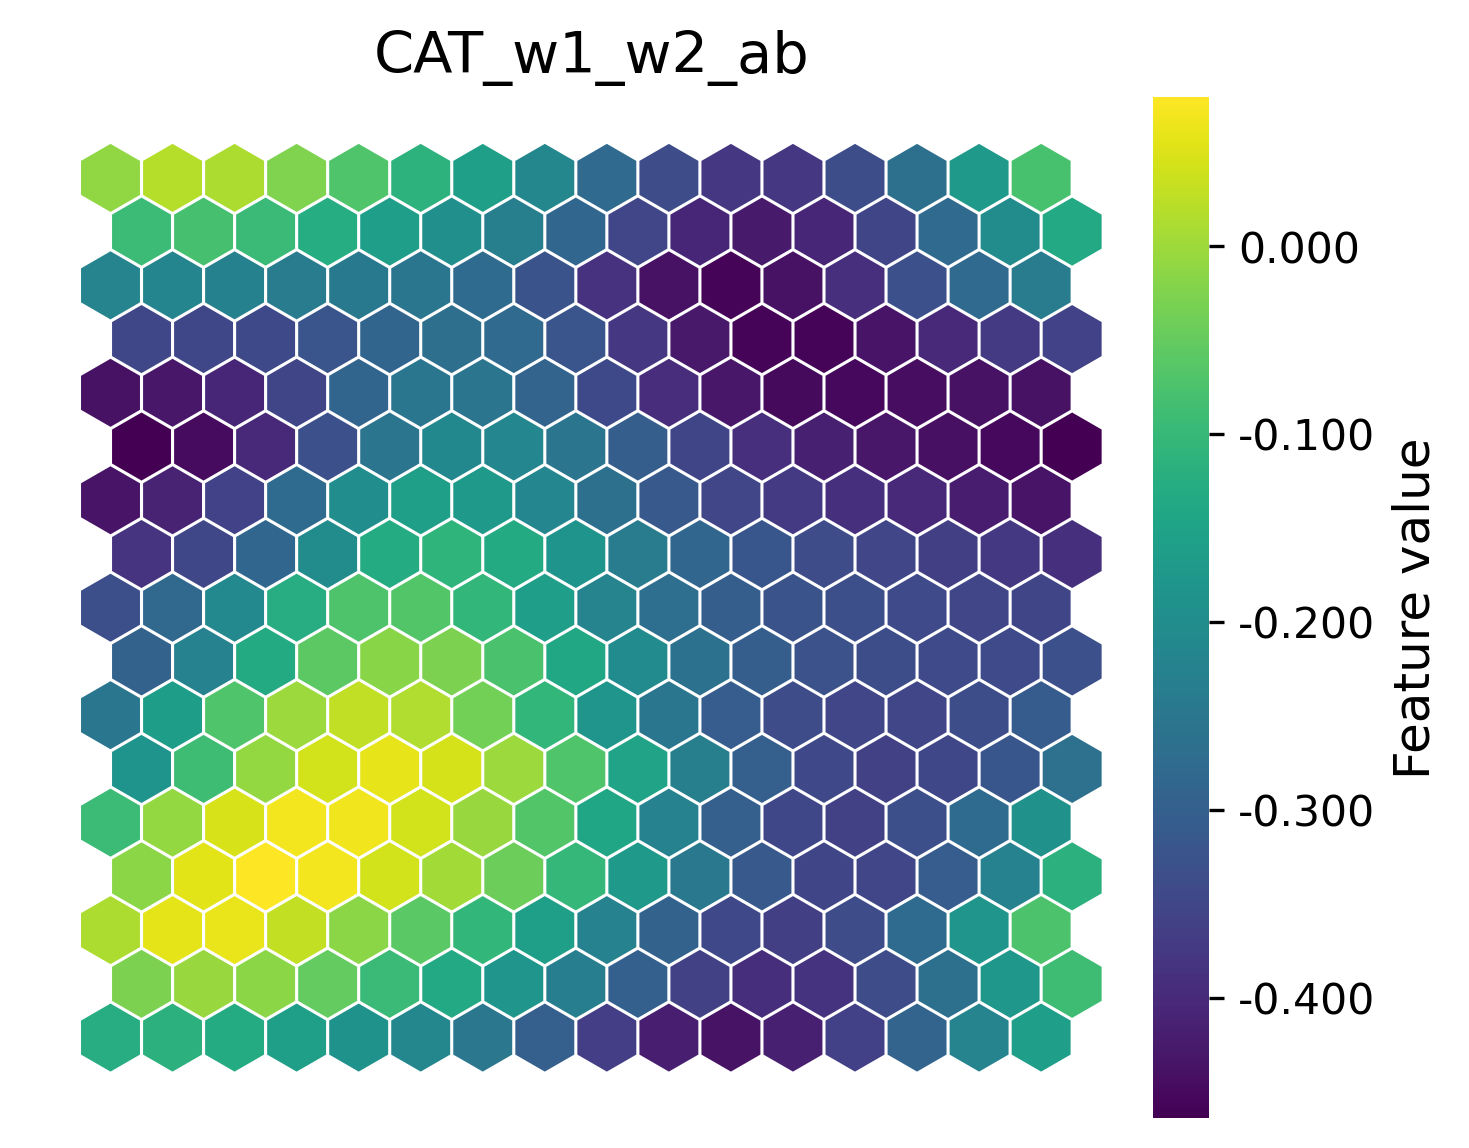

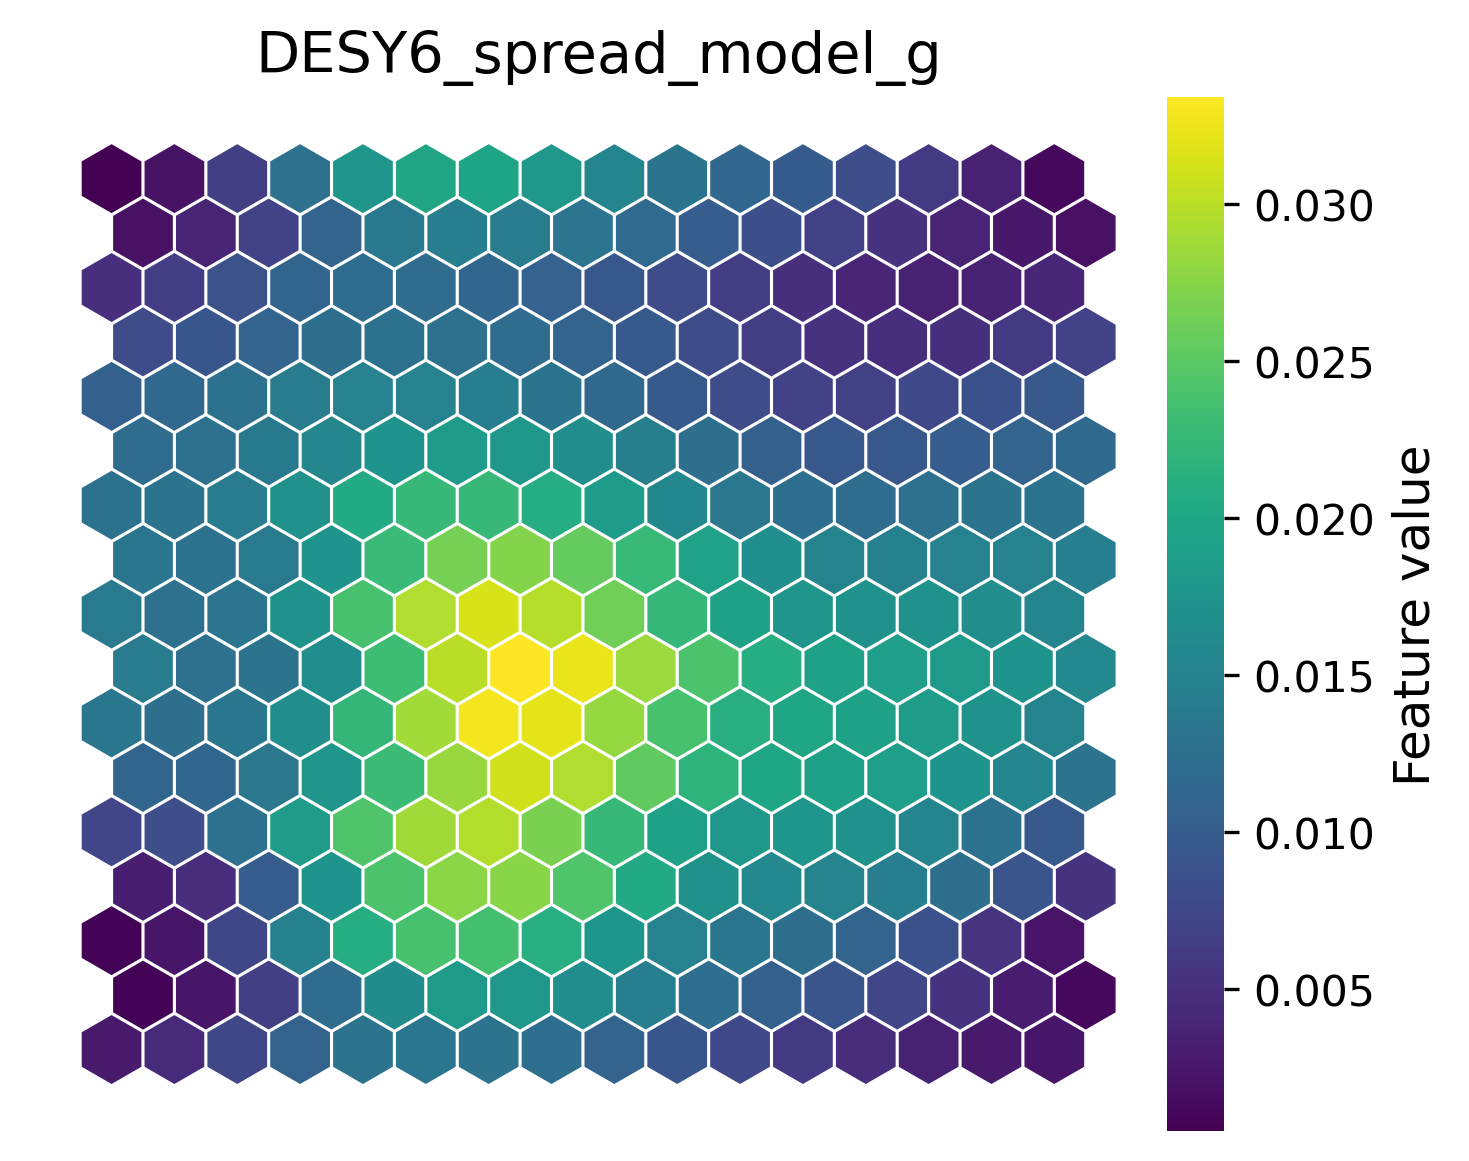

In [ ]:
all_positions = [[node.pos[0], node.pos[1]] for node in best_som.nodes_list]
all_weights = [[node.weights[feature_idx] for feature_idx in range(len(som_columns))] for node in best_som.nodes_list]

# convert back to the original feature space
weights_dewhitened = inverse_pca_whitening(data, all_weights)

# Plot the dewhitned features
for idx in range(len(som_columns)):
    weights_dewhitened_feature = [weights_dewhitened[row][idx] for row in range(len(weights_dewhitened))]
    
    hexagon = sps.polygons.Hexagons

    sps.plots.plot_map(
        all_positions,
        weights_dewhitened_feature,
        hexagon,
        title = f'{som_columns[idx]}',
        show = False,
        print_out = True
    )

### Comparison of prototype values with original values

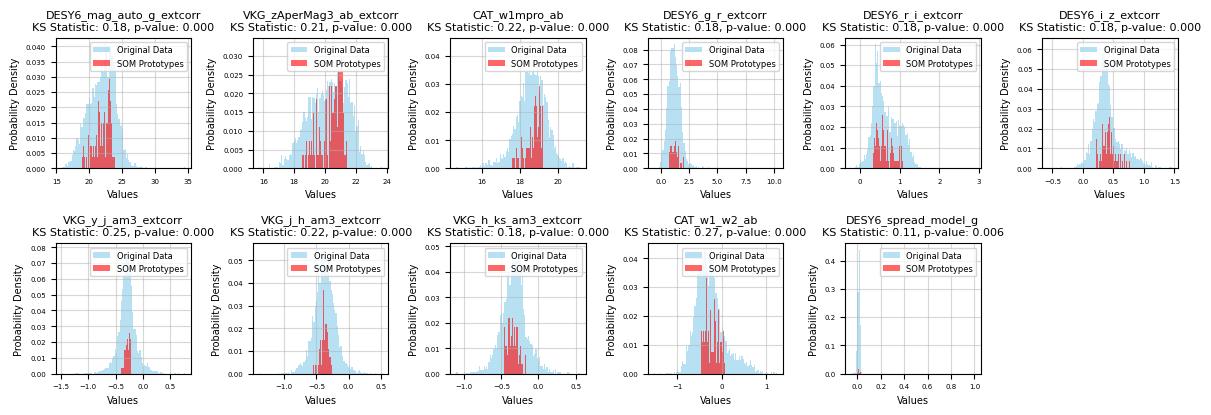

In [ ]:
num_cols = 6
num_rows = 3        
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for i, col in enumerate(som_columns):
    if i < len(axes):
        ax = axes[i]
        original_data = catalog_som[col]
        som_column_data = [weights_dewhitened[row][som_columns.index(col)] for row in range(len(weights_dewhitened))]

        # Histogram of the original data
        ax.hist(original_data, weights=np.ones(len(original_data)) / len(original_data), bins=100, alpha=0.6, label='Original Data', color='skyblue')

        # Histogram of the dewhitened prototypes
        ax.hist(som_column_data, weights=np.ones(len(som_column_data)) / len(som_column_data), bins=100, alpha=0.6, label='SOM Prototypes', color='red')

        # Kolmogorov-Smirnov test: how similar are the distributions?
        ks_statistic, p_value = kstest(original_data, som_column_data)
        ax.set_title(f'{col}\nKS Statistic: {ks_statistic:.2f}, p-value: {p_value:.3f}', fontsize=8)


        ax.set_xlabel('Values', fontsize=7)
        ax.set_ylabel('Probability Density', fontsize=7)
        ax.legend(fontsize=6)
        ax.grid(True, alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=5)

# Remove any unused subplots
if len(som_columns) < len(axes):
    for j in range(len(som_columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Find the data points for each node

In [ ]:
# simpsom.network.SOMNode object at 'hexcode'
nodes = best_som.nodes_list

print(nodes)
bmus = best_som.find_bmu_ix(data_white)
print(bmus)

nodes_data_dict = {}

# Key= node object, Value = data index
for node in nodes:
    node_indices = [idx for idx in range(len(data_white)) if nodes[bmus[idx]] == node]
    nodes_data_dict[node] = node_indices

print(nodes_data_dict)

[<simpsom.network.SOMNode object at 0x727204c7f7c0>, <simpsom.network.SOMNode object at 0x72720799e800>, <simpsom.network.SOMNode object at 0x727204c7f100>, <simpsom.network.SOMNode object at 0x727204c7e9e0>, <simpsom.network.SOMNode object at 0x727204c7fdc0>, <simpsom.network.SOMNode object at 0x727204c97a00>, <simpsom.network.SOMNode object at 0x727204c97220>, <simpsom.network.SOMNode object at 0x727204c977c0>, <simpsom.network.SOMNode object at 0x727204c95de0>, <simpsom.network.SOMNode object at 0x727204c96e60>, <simpsom.network.SOMNode object at 0x727204c95900>, <simpsom.network.SOMNode object at 0x727204c97400>, <simpsom.network.SOMNode object at 0x727204c97880>, <simpsom.network.SOMNode object at 0x727204c96fe0>, <simpsom.network.SOMNode object at 0x727204c96860>, <simpsom.network.SOMNode object at 0x727204c97ca0>, <simpsom.network.SOMNode object at 0x727204c95ae0>, <simpsom.network.SOMNode object at 0x727204c968c0>, <simpsom.network.SOMNode object at 0x727204c97460>, <simpsom.ne

{<simpsom.network.SOMNode object at 0x727204c7f7c0>: [781, 1046, 1100, 1173, 1236, 2251, 2316, 2413, 2582], <simpsom.network.SOMNode object at 0x72720799e800>: [58, 233, 295, 345, 867, 1049, 1162, 1178, 1523, 1550, 1621, 1654, 1833, 2004, 2162, 2238, 2928], <simpsom.network.SOMNode object at 0x727204c7f100>: [20, 301, 332, 370, 805, 983, 1537, 1559, 1671, 1723, 1869, 2176, 2281, 2410, 2660, 2734, 3159, 3346, 3385], <simpsom.network.SOMNode object at 0x727204c7e9e0>: [78, 422, 445, 1177, 1503, 1592, 1613, 1809, 2021, 2069, 2096, 2254, 2436, 2537, 2645, 2826, 3010, 3211, 3282, 3333, 3374], <simpsom.network.SOMNode object at 0x727204c7fdc0>: [101, 916, 1427, 1626, 1629, 2050, 2054, 2171, 2202, 2314, 2431, 2448, 2670, 2982, 3014, 3388], <simpsom.network.SOMNode object at 0x727204c97a00>: [161, 255, 481, 1102, 1748, 1953, 2397, 3104, 3307, 3362], <simpsom.network.SOMNode object at 0x727204c97220>: [1164, 3177, 3234], <simpsom.network.SOMNode object at 0x727204c977c0>: [1120, 1284, 1790, 248

### Save the Galaxy Prototypes

In [ ]:
# Create a dataframe with the weights for easier access
all_weights = [[node.weights[feature_idx] for feature_idx in range(len(som_columns))] for node in som.nodes_list]

prototypes_df = pd.DataFrame(all_weights, som_columns)

######################################################################################################################################
prototypes_df['id'] = ['node ' + str(idx) for idx in range(len(all_weights))]
prototypes_df['redshift'] = [-1 for _ in range(len(all_weights))]

Convert the prototype colors to prototype magnitudes and save it in the the dataframe

In [ ]:
# DES Y6 GOLD
prototypes_df['DESY6_magerr_auto_r_extcorr'] = prototypes_df['DESY6_mag_auto_g_extcorr'] - prototypes_df['DESY6_g_r_extcorr']
prototypes_df['DESY6_magerr_auto_i_extcorr'] = prototypes_df['DESY6_mag_auto_r_extcorr'] - prototypes_df['DESY6_r_i_extcorr']
prototypes_df['DESY6_magerr_auto_z_extcorr'] = prototypes_df['DESY6_mag_auto_i_extcorr'] - prototypes_df['DESY6_i_z_extcorr']

# VIKING
prototypes_df['VKG_magerr_petro_j_extcorr'] = prototypes_df['VKG_mag_petro_y_ab_extcorr'] - prototypes_df['VKG_y_j_petro_extcorr']
prototypes_df['VKG_magerr_petro_h_extcorr'] = prototypes_df['VKG_magerr_petro_j_extcorr'] - prototypes_df['VKG_j_h_petro_extcorr']
prototypes_df['VKG_magerr_petro_ks_extcorr'] = prototypes_df['VKG_magerr_petro_h_extcorr'] - prototypes_df['VKG_h_ks_petro_extcorr']

# CATWISE
prototypes_df['CAT_w2sigmpro_extcorr'] = prototypes_df['CAT_w1mpro_ab'] - prototypes_df['CAT_w1_w2_ab']

Calculate the fluxes and add them to a new dataframe. Add id and redshift

In [ ]:
# Create a dataframe and save a file for use in CIGALE
prots_cigale_df = pd.DataFrame()

prots_cigale_df = 

In [ ]:

# Convert the colors to magnitudes and then to fluxes
# DES
prots_cigale_df['ctio.decam.g'] = 10 ** (6.56-0.4 * [])
prots_cigale_df['ctio.decam.r'] = 10 ** (6.56-0.4 * [])
prots_cigale_df['ctio.decam.i'] = 10 ** (6.56-0.4 * [])
prots_cigale_df['ctio.decam.z'] = 10 ** (6.56-0.4 * [])

# VIKING
prots_cigale_df['paranal.vircam.Y'] = 10 ** (6.56-0.4 * [])
prots_cigale_df['paranal.vircam.J'] = 10 ** (6.56-0.4 * [])
prots_cigale_df['paranal.vircam.H'] = 10 ** (6.56-0.4 * [])
prots_cigale_df['paranal.vircam.Ks'] = 10 ** (6.56-0.4 * [])

# CATWISE
prots_cigale_df['wise.W1'] = 10 ** (6.56-0.4 * [])
prots_cigale_df['wise.W2'] = 10 ** (6.56-0.4 * [])


# Save the dataframe
prots_cigale_file_path = directory + 'soms/prototypes_cigale.fit'
prots_cigale_table = Table.from_pandas(prots_cigale_df)
prots_cigale_table.write(prots_cigale_file_path, overwrite=True)

Calculate the erros as 10% of the fluxes. Other option would be to use the median values of the errors of the datapoints that have those nodes as best matching units.

In [ ]:
# Calculate the errors (10% of the fluxes)
# DES
prototypes_df['ctio.decam.g_err'] = prototypes_df['ctio.decam.g'] * 0.1
prototypes_df['ctio.decam.r_err'] = prototypes_df['ctio.decam.r'] * 0.1
prototypes_df['ctio.decam.i_err'] = prototypes_df['ctio.decam.i'] * 0.1
prototypes_df['ctio.decam.z_err'] = prototypes_df['ctio.decam.z'] * 0.1

# VIKING
prototypes_df['paranal.vircam.Y_err'] = prototypes_df['paranal.vircam.Y'] * 0.1
prototypes_df['paranal.vircam.J_err'] = prototypes_df['paranal.vircam.J'] * 0.1
prototypes_df['paranal.vircam.H_err'] = prototypes_df['paranal.vircam.H'] * 0.1
prototypes_df['paranal.vircam.Ks_err'] = prototypes_df['paranal.vircam.Ks'] * 0.1

# CATWISE
prototypes_df['wise.W1_err'] = prototypes_df['wise.W1'] * 0.1
prototypes_df['wise.W2_err'] = prototypes_df['wise.W2'] * 0.1

Save the dataframe as a file